ML - PAIR EXECUTION
---

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


import openpyxl

In [2]:
#  CDNS & SNPS (Cadence Design Systems and Synopsy)
stock1 = 'CDNS'
stock2 = 'SNPS'

data = yf.download([stock1, stock2], start='2020-01-01', end='2025-03-10')['Close']
data.dropna(inplace=True)
data.head(2)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  2 of 2 completed


Ticker,CDNS,SNPS
Date,,
2020-01-02,71.440002,142.869995
2020-01-03,70.419998,141.759995


In [3]:
# Calculate spread
initial_scale = data[stock1].iloc[0] / data[stock2].iloc[0]
stock2_scaled = data[stock2] * initial_scale
spread = ((data[stock1] - stock2_scaled) / (data[stock1] + stock2_scaled)) * 100
spread.head(2)

Date
2020-01-02    0.000000
2020-01-03   -0.329051
dtype: float64

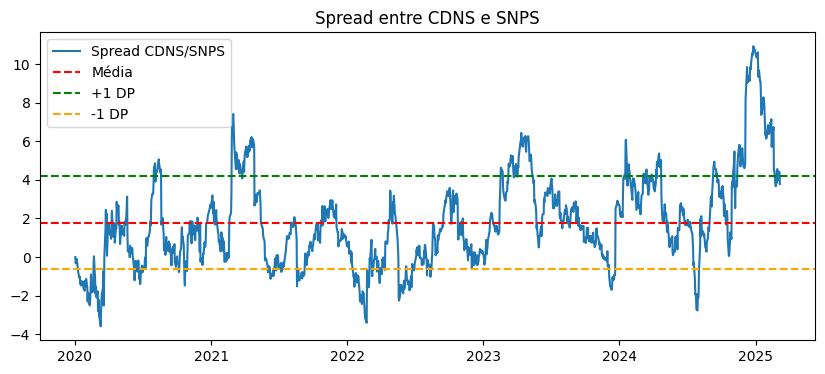

In [4]:
# Plot spread
plt.figure(figsize=(10, 4))
plt.plot(spread, label=f'Spread {stock1}/{stock2}')
plt.axhline(spread.mean(), color='red', linestyle='--', label='Média')
plt.axhline(spread.mean() + spread.std(), color='green', linestyle='--', label='+1 DP')
plt.axhline(spread.mean() - spread.std(), color='orange', linestyle='--', label='-1 DP')
plt.legend()
plt.title(f'Spread entre {stock1} e {stock2}')
plt.show()

In [5]:
'''
Input Data:

    Historical prices for both stocks in the pair
    Spread (calculated as Stock1 - Stock2)
    Indicators (Moving Average, Z-score, Bollinger Bands, etc.)
    Market conditions (volatility, volume, macro factors)
'''

window = 20  # Moving average window

features = pd.DataFrame(index=data.index)
features['Spread'] = spread
features['Z-Score'] = (spread - spread.rolling(window).mean()) / spread.rolling(window).std()
features['Spread_MA'] = spread.rolling(window).mean()
features['Spread_Std'] = spread.rolling(window).std()
features['Rolling_Corr'] = data['CDNS'].rolling(window).corr(data['SNPS'])

def rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

features['RSI'] = rsi(spread)
features['Bollinger_Width'] = (features['Spread_Std'] * 2) / features['Spread_MA']
features.dropna(inplace=True)

features.dropna(inplace=True)
features.head(5)

,Spread,Z-Score,Spread_MA,Spread_Std,Rolling_Corr,RSI,Bollinger_Width
Date,,,,,,,
2020-01-30,-1.517940,-0.932340,-1.019347,0.534776,0.963164,34.380124,-1.049251
2020-01-31,-1.131255,-0.115759,-1.075910,0.478109,0.963161,44.726845,-0.888754
2020-02-03,-1.557973,-0.923403,-1.137356,0.455508,0.948271,42.168704,-0.800994
2020-02-04,-2.291373,-2.287208,-1.246814,0.456696,0.928030,33.349142,-0.732581
2020-02-05,-1.842698,-1.246656,-1.324393,0.415757,0.908180,44.142849,-0.627845


In [6]:
# Labeling Trades
'''
Labels (EXAMPLE):

    Long (Buy Stock 1, Sell Stock 2) → When the spread is too low (below -1 standard deviation)
    Short (Sell Stock 1, Buy Stock 2) → When the spread is too high (above +1 standard deviation)
    Hold (No trade) → When the spread is within the neutral range
    If spread is above the mean but below the upper threshold, it gets a new label 2 (Slightly Bullish).
    If spread is below the mean but above the lower threshold, it gets a new label -2 (Slightly Bearish).

    short - 0
    ------------------
    between mean and upper - 1 

    --------------
    between mean and lower - 2 

    -------------------
    long - 3

    --> Choose your trading method! --> you can use z-score, moving averages, bollinger bands, bands across the ratio...
'''


def label_trades(row):
    upper_threshold = row['Spread_MA'] + row['Spread_Std']
    lower_threshold = row['Spread_MA'] - row['Spread_Std']
    
    if row['Spread'] > upper_threshold:
        return 0  # Short Trade
    elif row['Spread'] < lower_threshold:
        return 3   # Long Trade
    elif row['Spread_MA'] <= row['Spread'] <= upper_threshold:
        return 1  # Slightly Bullish
    elif lower_threshold <= row['Spread'] <= row['Spread_MA']:
        return 2  # Slightly Bearish
    return 4  # Hold

features['Trade_Signal'] = features.apply(label_trades, axis=1)
features.head()

,Spread,Z-Score,Spread_MA,Spread_Std,Rolling_Corr,RSI,Bollinger_Width,Trade_Signal
Date,,,,,,,,
2020-01-30,-1.517940,-0.932340,-1.019347,0.534776,0.963164,34.380124,-1.049251,2
2020-01-31,-1.131255,-0.115759,-1.075910,0.478109,0.963161,44.726845,-0.888754,2
2020-02-03,-1.557973,-0.923403,-1.137356,0.455508,0.948271,42.168704,-0.800994,2
2020-02-04,-2.291373,-2.287208,-1.246814,0.456696,0.928030,33.349142,-0.732581,3
2020-02-05,-1.842698,-1.246656,-1.324393,0.415757,0.908180,44.142849,-0.627845,3


In [7]:
# Split Data -->RANDOM
X = features.drop(columns=['Trade_Signal'])
y = features['Trade_Signal']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#With this slipt
#Every time we run the code, we get the same train-test split
#Always testing on the same dataset, making comparisons meaningful
#The train and test sets have the same distribution of labels, preventing imbalance issues.

# Train Random Forest Model --> you have multiple options >> XGBoost or LSTMs 

rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        70
           1       0.92      0.98      0.95        58
           2       0.98      0.91      0.95        57
           3       1.00      1.00      1.00        72

    accuracy                           0.98       257
   macro avg       0.98      0.97      0.97       257
weighted avg       0.98      0.98      0.98       257



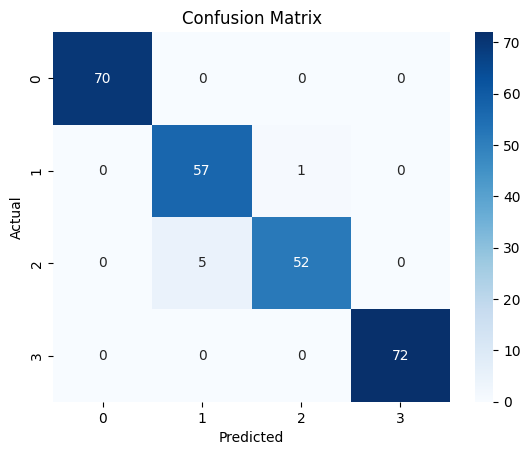

In [8]:
# Model Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [9]:
print(f"Training set size: {len(X_train)}, Test set size: {len(X_test)}")
print("Checking for overlaps:", X_train.index.intersection(X_test.index))

Training set size: 1026, Test set size: 257
Checking for overlaps: DatetimeIndex([], dtype='datetime64[ns]', name='Date', freq=None)


In [10]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_model

RandomForestClassifier(max_depth=5, random_state=42)

In [11]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=42)

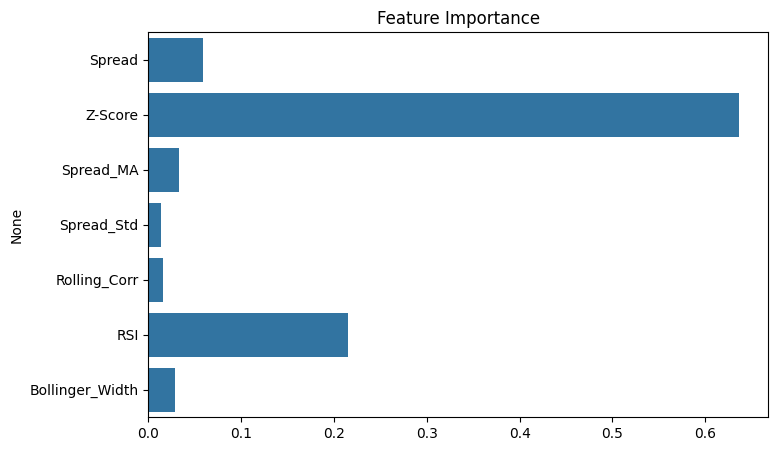

In [12]:
importances = rf_model.feature_importances_
feature_names = X_train.columns

plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importance")
plt.show()

In [13]:
# Split Data --> last 20% of the dataset 

features = features.sort_index()

# Define split index (last 20% of the dataset)
split_idx = int(len(features) * 0.8)

X_train, X_test = features.iloc[:split_idx].drop(columns=['Trade_Signal']), features.iloc[split_idx:].drop(columns=['Trade_Signal'])
y_train, y_test = features.iloc[:split_idx]['Trade_Signal'], features.iloc[split_idx:]['Trade_Signal']

# Print sizes to confirm
print(f"Training set size: {len(X_train)}, Test set size: {len(X_test)}")

Training set size: 1026, Test set size: 257


In [14]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        69
           1       0.88      0.97      0.92        60
           2       0.95      0.83      0.89        48
           3       1.00      1.00      1.00        80

    accuracy                           0.96       257
   macro avg       0.96      0.95      0.95       257
weighted avg       0.96      0.96      0.96       257



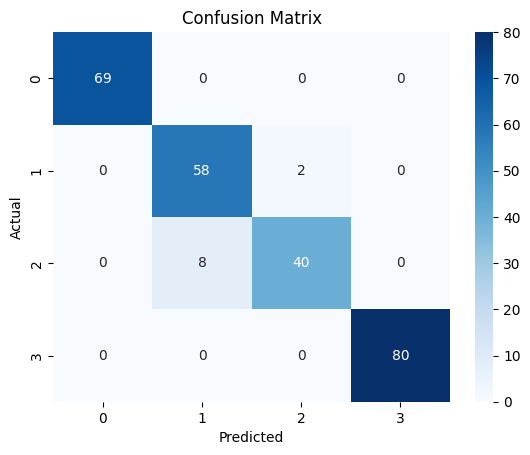

In [15]:
# Model Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()